# DESCQA-SRV photometry errors

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook details the DESCQA-SRV photometry errors test. This test covers checks on the error distribution for the fluxes, and can be run on the command line for the full dp0.2 catalog using 

```bash
 ./run_master.sh -t srv_photometry_errors -c dp02
```


This test looks at the error distributions of the photometry and compares them to that expected from a Gaussian distributed error. This uses the truth-matched photometry to see the "true" error distributions.

These error distributions can be hard to interpret. You should keep a few things in mind here:
- This test would require a source-injected sample or comparison with an external catalog in real data
- Not all flux measurements are intended to match the input magnitudes - for instance psf fluxes and small aperture measurements will be biased with respect to total galaxy magnitudes
- Error distributions may not be Gaussian, in particular the conversion from flux to magnitude may render an initially symmetric flux error asymmetric in magnitude-space

## Photometry options

There are several flux measurements available in the schema, these are 
- psfFlux measurements
    - Flux derived from PSF model (free_psfFlux for non-forced measurement)
- aperture fluxes
    - Fluxes forced within apertures of 3, 6, 9, 12, 17, 25, 35, 50 and 70 pixels
- calib flux 
    - Flux in 12 pixel aperture
- gaap fluxes
    - Gaussian aperture fluxes in 0.5, 0.7, 1.0, 1.5, 2.5, 3.0 arcsec, optimal and PSF apertures after multiplying seeing by 1.15 (forced). See srv_gaap for more details. 
- cModel fluxes
    - combination of exponential (bdFluxD) and de Vaucouleurs (bdFluxB) fits, also given individually
- kron Flux
    - Flux within the Kron radius, radius given by kronRad
    
In general the recommended flux measurements are psfFlux for stars, cModel fluxes for galaxy magnitudes, and gaap fluxes for galaxy colors. 


## Rubin tests

#### Matched visits (all visits for each source)
As the matched visits have multiple measurements of the same objects, they use these to test how repeatible the measurements are. 
- stellarPhotometricRepeatability
- stellarPhotometricResiduals (using psfFlux, plotted on the focal plane)

#### Object Catalog (measured from coadds)
- validPsfFluxMetric: column checks for numbers being within reasonable ranges
- validCmodelFluxMetric: column checks for numbers being within reasonable ranges
- psfCModelScatter: scatter plot of cModel vs psfFlux
- wPerpPSFP: width of blue portion of the stellar locus in (r-i) vs. (g-r) 
- wPerpCModel: width of blue portion of the stellar locus in (r-i) vs. (g-r) 
- xPerpPSF: width of red portion of the stellar locus in (r-i) vs. (g-r) 
- xPerpCModel: width of red portion of the stellar locus in (r-i) vs. (g-r) 
- ap12PsfSky: difference between 12 pixel aperture and psfFlux over the sky



We do the initial pre-amble, with a couple of exceptions: firstly we import the [qp package](https://github.com/LSSTDESC/qp). This allows us to make use of the software that has been developed for error analysis within the PZ group, in particular by Alex Malz. Secondly we read in a matched set of stars. This will take a minute longer than usual to do the matching.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.colors as mcolors
import math
import time
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/srv_packages/site-packages/')
import qp
from scipy.stats import chi2
from scipy import stats
from utils import *
from pyarrow import dataset as ds
import pandas
import numpy as np
from pyarrow import compute as pc

catalog = GCRCatalogs.load_catalog('lsst_object')
matched_table = get_matched_catalog_stars()
matched_table_galaxies = get_matched_catalog()

%matplotlib inline

We define the main function below - this takes the central flux values and errors and creates an ensemble of normal distributions with those parameters. We then take a truth sample and evaluate the cumulative distribution function (cdf) at these points. 

This gives us the probability integral transform. We plot this alongside the expected distribution from a sample coming from this distribution, also plotting the relationship between the magnitude and the error in magnitude, and the residuals as a function of truth flux. 

In [144]:

def get_chi2_plots_from_dist(loc, scale, sample, dist_name, lower_limit, upper_limit, color=False):

    ens_n = qp.Ensemble(qp.stats.norm, data=dict(loc=loc, scale=scale))
    # ensemble of gaussian distributions
    
    cdf_vals = ens_n.cdf(sample)
    if not color:
        plt.figure()
        plt.scatter(convert_nanoJansky_to_mag(loc),convert_flux_err_to_mag_err(loc,scale),s=0.1)
        plt.xlabel('magnitude')
        plt.ylabel('Error in magnitude')
        plt.show()
        plt.close()
    
    # create histogram 
    plt.figure()
    a,b,c = plt.hist(cdf_vals.flatten(),bins=30)
    bin_widths = b[1:]-b[:-1]
    
    ngals = len(loc)
    ci = (a - ngals*bin_widths)**2/(ngals*bin_widths)
    x2 = np.sum(ci)

    # create expected value 
    plt.plot(b,ngals*bin_widths[0]*np.ones_like(b),'r--',linewidth=2, label='uniform distribution, chi2/dof = '+str(x2/30))
    plt.xlim([0,1.0])
    plt.xlabel('probability')
    plt.ylabel('frequency')
    plt.yscale('log')
    plt.legend()
    plt.show()
    #plt.savefig(os.path.join(outdir,'PIT_'+dist_name+'.png'))
    plt.close()
    
    if color:
        plt.figure()
        plt.scatter(np.log10(sample),(loc-sample)/scale, s=1.0)
        plt.plot(np.linspace(-3,1,100),np.zeros(100),'k--',linewidth=2)
        plt.ylabel('residual/1sigma error')
        plt.xlabel('log10(flux): truth')
        #plt.savefig(os.path.join(outdir,'fluxerr_'+dist_name+'.png'))
        plt.xlim([-3,1])
        plt.ylim([-10,10])
        plt.show()

    else:
        plt.figure()
        plt.scatter(np.log10(sample),(loc-sample)/scale, s=1.0)
        plt.plot(np.linspace(1.5,5,100),np.zeros(100),'k--',linewidth=2)
        plt.ylabel('residual/1sigma error')
        plt.xlabel('log10(flux): truth')
        #plt.savefig(os.path.join(outdir,'fluxerr_'+dist_name+'.png'))
        plt.xlim([1.5,5])
        plt.ylim([-20,20])
        plt.show()

    plt.close()
    # compute chi2 value 
    ci = (a - ngals*bin_widths)**2/(ngals*bin_widths)
    x2 = np.sum(ci)
        
    print("Statistics for ",dist_name)
    print("-------------------------")
    
    eval_grid = np.linspace(0, 1, 2000)
    data_quants = np.quantile(ens_n.cdf(sample), eval_grid)
    print('outlier rate:')
    print('low outlier fraction: ', np.sum(data_quants<lower_limit)/2000., 'high outlier fraction: ', np.sum(data_quants>upper_limit)/2000.)

    # necessary inputs for other statistics 
    trimmed_pit_values = data_quants[(eval_grid>=lower_limit)&(eval_grid<=upper_limit)]
    uniform_yvals = np.linspace(lower_limit, upper_limit, len(trimmed_pit_values))
    
    # some extra tests on the PIT - let's add more details on what they mean 
    print(quick_anderson_ksamp(trimmed_pit_values, uniform_yvals))
    print(stats.kstest(ens_n.cdf(sample), stats.uniform.cdf))
    print(stats.cramervonmises(ens_n.cdf(sample), stats.uniform.cdf))

    return x2/30.


We run this test after applying standard flags, and a cut on signal-to-noise and i-band magnitude 

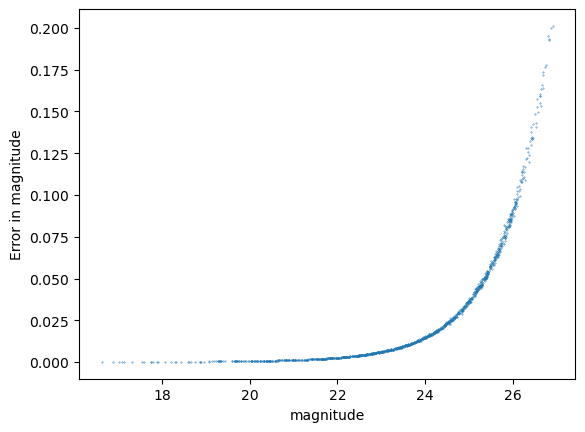

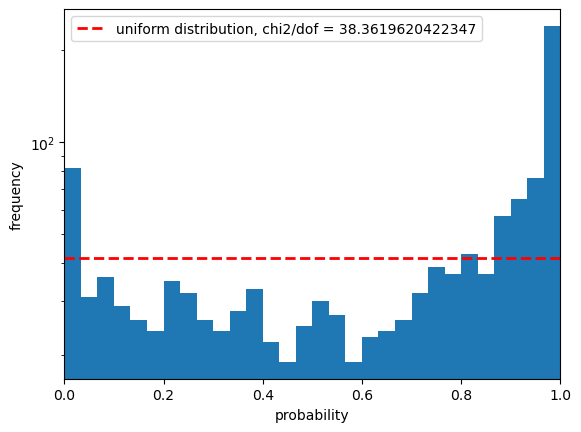

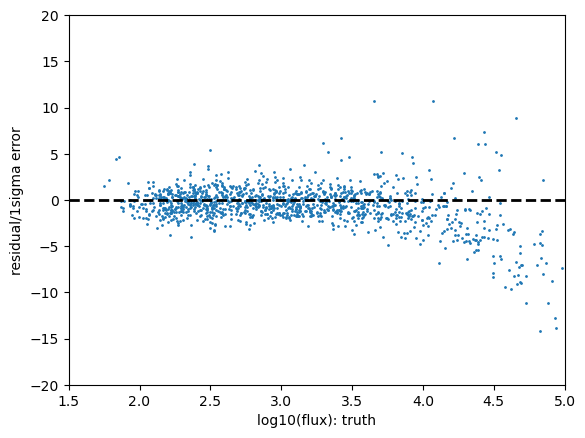

Statistics for  psf_r
-------------------------
outlier rate:
low outlier fraction:  0.019 high outlier fraction:  0.0785
Anderson_ksampResult(statistic=145.81018926586992, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
KstestResult(statistic=0.22039646656459888, pvalue=1.1222998910327198e-53, statistic_location=0.8579265387378145, statistic_sign=-1)
CramerVonMisesResult(statistic=23.47932191429345, pvalue=1.0340944767150972e-09)


/global/cfs/projectdirs/lsst/groups/SRV/srv_packages/site-packages/qp/metrics/array_metrics.py:26: UserWarning: p-value floored: true value smaller than 0.001
  return stats.anderson_ksamp([p_random_variables, q_random_variables], **kwargs)


In [83]:
bands=['r']
models=['psf','free_psf','cModel']
band = 'r'

snr_cut = 5.0
mag_cut_i = 25.3
mag_cut_max = 15
model = 'psf'
for band in bands:
    # cut on signal to noise of measured values
    mask_flags = (matched_table[band+'_'+model+'Flux'])/(matched_table[band+'_'+model+'FluxErr'])>snr_cut
    mask_flags = mask_flags&(matched_table[band+'_extendedness']==0)
    mask_flags = mask_flags&(matched_table['detect_isPrimary'])&(matched_table['detect_isIsolated'])
    if model=='cModel':
        # if cModel then the flag is cModel_flag rather than cModelFlux_flag, and we add an apCorr flag
        mask_flags = mask_flags&(~matched_table[band+'_'+model+'_flag'])&(~matched_table[band+'_'+model+'_flag_apCorr'])
    else:
        mask_flags = mask_flags&(~matched_table[band+'_'+model+'Flux_flag'])
    # add a magnitude cut    
    cut_mag = convert_nanoJansky_to_mag(matched_table['flux_i'][mask_flags])<mag_cut_i
    cut_mag = cut_mag&(convert_nanoJansky_to_mag(matched_table['flux_i'][mask_flags])>mag_cut_max)

    loc = matched_table[band+'_'+model+'Flux'][mask_flags&cut_mag]
    scale = matched_table[band+'_'+model+'FluxErr'][mask_flags&cut_mag]
    sample = matched_table['flux_'+band][mask_flags&cut_mag]

    test_result = get_chi2_plots_from_dist(loc,scale,sample,model+'_'+band,0.0001,0.9999)



## Results
The above shows the r-band result for the psfFlux. You see that the magnitude error distribution follows a tight relation as expected, however this does significantly differ from a Gaussian distribution with that error distribution. Due to our small sample size in this inspection we have not made any attempt to apply pixel flags to exclude inexact PSF measurements or saturated pixels, so this is not cause for any particular concern.  

The PIT plot shows some excess populations at the outskirts of the probability distributions. You can also see this in the residual plot by some excess points at strongly positive residuals at all magnitudes, and a negative bias at the higher fluxes. We could improve this result by cutting out bright galaxies or using more cuts - try running again with a different mag_cut_max set, or setting the _pixelFlags_inexact_psfCenter flag and you should see significantly better results. 


### Statistics
Let's discuss the statistics a little more. 

The rate of outliers beyond the 0.01% likelihoods are roughly 2% low outliers and 8% high outliers. This is fairly self-explanatory, one would expect the numbers in a Gaussian distribution to be around 0.01% however the clear presence of outliers in this sample renders it much higher. Due to our small sample size in this inspection we have not made any attempt to apply pixel flags to exclude inexact PSF measurements or saturated pixels. 

The following statistics compare the a uniform sample of probabilities to our PIT sample, to see how close the line in the second figure is to the distribution. As visually these do not look like a good match it should be unsurprising that they all agree that this doesn't look like Gaussian-distributed errors!

The Anderson ksamp test refers to the [k-sample Anderson-Darling test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html). The number we get here is 145.8 in the statistic, which is higher than all the critical values in the array (these are capped at a 25% and 0.1% significance level), so we reject the hypothesis that this CDF is a uniform distribution at beyond the 0.1% significance level. The p value we get is below 0.001, beyond the bounds of the test. 

Next we perform a KS or [Kolmogorov-Smirnov](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) test. This again is testing whether our sample matches a uniform distribution, and we see a p value which is extremely low, suggesting that we can exclude this to a high probability. 

Finally we look at the [Cramer-Von Mises](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html) test. Here the p-value is 10^-9, which again suggests we can exclude the null hypothesis that this PIT matches a uniform distribution to a high probability. 



## A "better" result

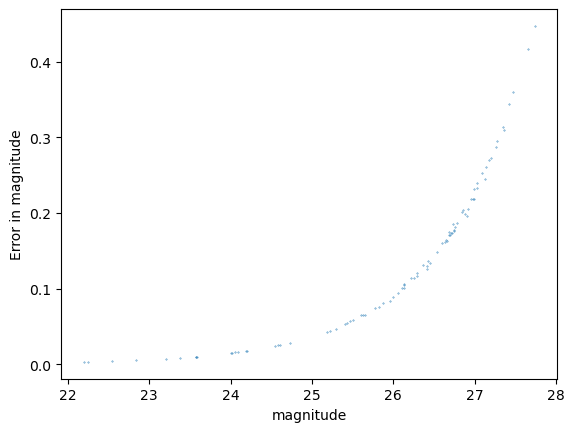

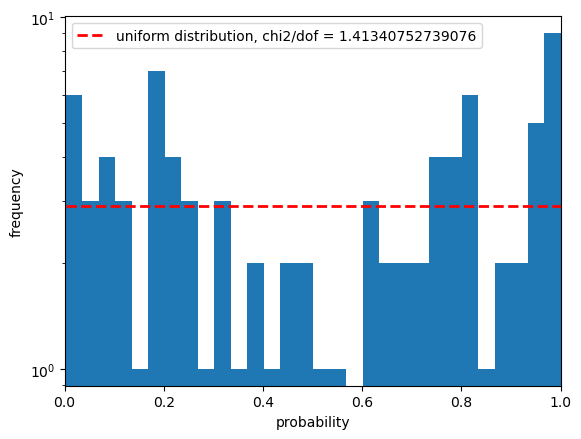

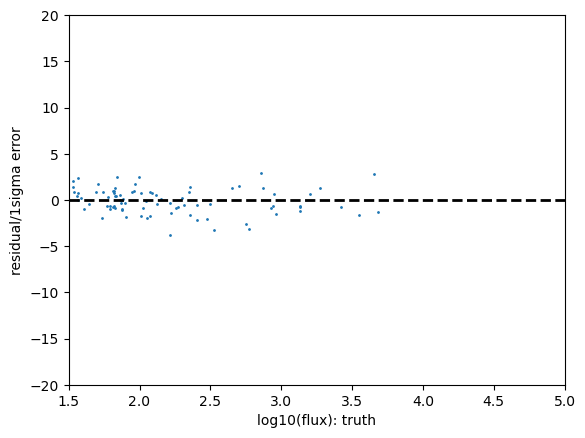

Statistics for  psf_r
-------------------------
outlier rate:
low outlier fraction:  0.0 high outlier fraction:  0.0005
Anderson_ksampResult(statistic=35.793237736836886, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
KstestResult(statistic=0.12678420482896746, pvalue=0.11173439628349692, statistic_location=0.7474738600013813, statistic_sign=-1)
CramerVonMisesResult(statistic=0.39337992563641716, pvalue=0.07501330828225883)


/global/cfs/projectdirs/lsst/groups/SRV/srv_packages/site-packages/qp/metrics/array_metrics.py:26: UserWarning: p-value floored: true value smaller than 0.001
  return stats.anderson_ksamp([p_random_variables, q_random_variables], **kwargs)


In [107]:
bands=['r']
models=['psf','free_psf','cModel']

band = 'r'
flag_list = [ band+'_pixelFlags_bad', band+'_pixelFlags_sensor_edgeCenter', band+'_pixelFlags_offimage', 
             band+'_pixelFlags_clippedCenter',band+'_pixelFlags_crCenter', band+'_pixelFlags_interpolatedCenter',
             band+'_pixelFlags_inexact_psfCenter', band+'_pixelFlags_edge', band+'_pixelFlags_suspectCenter',
             band+'_pixelFlags_saturatedCenter', band+'_pixelFlags_clipped', band+'_pixelFlags_cr',
             band+'_pixelFlags_interpolated', band+'_pixelFlags_saturated', band+'_pixelFlags_sensor_edge',
             band+'_pixelFlags_suspect']


snr_cut = 1.0
mag_cut_i = 28
mag_cut_max = 20
model = 'psf'
for band in bands:
    # cut on signal to noise of measured values
    mask_flags = (matched_table[band+'_'+model+'Flux'])/(matched_table[band+'_'+model+'FluxErr'])>snr_cut
    mask_flags = mask_flags&(matched_table[band+'_extendedness']==0)
    for flag in flag_list:
        mask_flags = mask_flags&(~matched_table[flag])
    mask_flags = mask_flags&(matched_table['detect_isPrimary'])&(matched_table['detect_isIsolated'])
    if model=='cModel':
        # if cModel then the flag is cModel_flag rather than cModelFlux_flag, and we add an apCorr flag
        mask_flags = mask_flags&(~matched_table[band+'_'+model+'_flag'])&(~matched_table[band+'_'+model+'_flag_apCorr'])
    else:
        mask_flags = mask_flags&(~matched_table[band+'_'+model+'Flux_flag'])
    # add a magnitude cut    
    cut_mag = convert_nanoJansky_to_mag(matched_table['flux_i'][mask_flags])<mag_cut_i
    cut_mag = cut_mag&(convert_nanoJansky_to_mag(matched_table['flux_i'][mask_flags])>mag_cut_max)

    loc = matched_table[band+'_'+model+'Flux'][mask_flags&cut_mag]
    scale = matched_table[band+'_'+model+'FluxErr'][mask_flags&cut_mag]
    sample = matched_table['flux_'+band][mask_flags&cut_mag]

    test_result = get_chi2_plots_from_dist(loc,scale,sample,model+'_'+band,0.0001,0.9999)



And now you can see why we didn't do this the first time around! The quality cuts help a lot but we are left with very few candidate stars on our little patch of sky. 

We see here the outlier fraction is a little high, the Anderson Darling test shows a strong likelihood that this can be excluded, but the KS test and the CVM tests are much less confident about this. 

## Galaxy flux measurements

Galaxies are again more complex - the issue being both that measurements may weight the inner and outer regions of the galaxies differently and that their shapes are more complex than point spread functions. For this reason we don't expect these tests to perform perfectly against the input "truth" measurements, however we can still use it to inspect our residuals and error properties. 

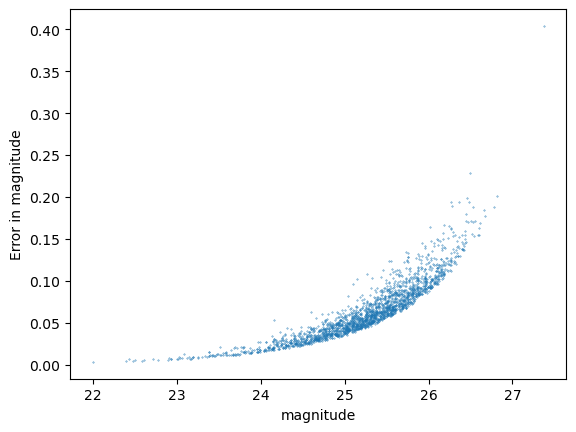

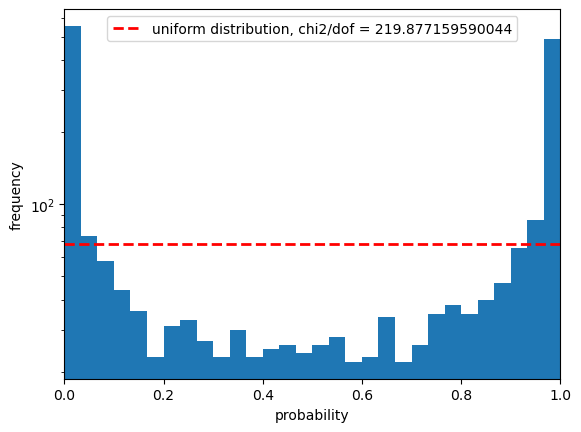

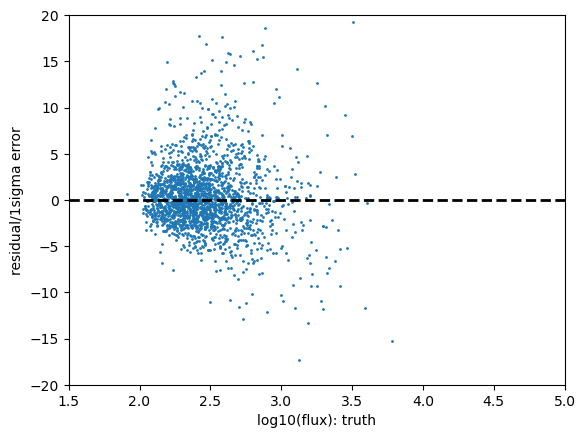

Statistics for  cModel_r
-------------------------
outlier rate:
low outlier fraction:  0.138 high outlier fraction:  0.088
Anderson_ksampResult(statistic=237.44576682958913, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
KstestResult(statistic=0.2436705947242885, pvalue=1.342820522128033e-107, statistic_location=0.06135624763783934, statistic_sign=1)
CramerVonMisesResult(statistic=50.889606674984954, pvalue=1.3633271844781802e-08)


/global/cfs/projectdirs/lsst/groups/SRV/srv_packages/site-packages/qp/metrics/array_metrics.py:26: UserWarning: p-value floored: true value smaller than 0.001
  return stats.anderson_ksamp([p_random_variables, q_random_variables], **kwargs)


In [148]:
bands=['r']
models=['psf','free_psf','cModel']
band = 'r'
flag_list = [ band+'_pixelFlags_bad', band+'_pixelFlags_sensor_edgeCenter', band+'_pixelFlags_offimage', 
             band+'_pixelFlags_clippedCenter',band+'_pixelFlags_crCenter', band+'_pixelFlags_interpolatedCenter',
             band+'_pixelFlags_inexact_psfCenter', band+'_pixelFlags_edge', band+'_pixelFlags_suspectCenter',
             band+'_pixelFlags_saturatedCenter', band+'_pixelFlags_clipped', band+'_pixelFlags_cr',
             band+'_pixelFlags_interpolated', band+'_pixelFlags_saturated', band+'_pixelFlags_sensor_edge',
             band+'_pixelFlags_suspect']


snr_cut = 1.0
mag_cut_i = 25.3
mag_cut_max = 20
model = 'cModel'
for band in bands:
    # cut on signal to noise of measured values
    mask_flags = (matched_table_galaxies[band+'_'+model+'Flux'])/(matched_table_galaxies[band+'_'+model+'FluxErr'])>snr_cut
    mask_flags = mask_flags&(matched_table_galaxies[band+'_extendedness']==1)
    mask_flags = mask_flags&(matched_table_galaxies['detect_isPrimary'])&(matched_table_galaxies['detect_isIsolated'])
    for flag in flag_list:
        mask_flags = mask_flags&(~matched_table_galaxies[flag])
    if model=='cModel':
        # if cModel then the flag is cModel_flag rather than cModelFlux_flag, and we add an apCorr flag
        mask_flags = mask_flags&(~matched_table_galaxies[band+'_'+model+'_flag'])&(~matched_table_galaxies[band+'_'+model+'_flag_apCorr'])
    else:
        mask_flags = mask_flags&(~matched_table_galaxies[band+'_'+model+'Flux_flag'])
    # add a magnitude cut    
    cut_mag = convert_nanoJansky_to_mag(matched_table_galaxies['flux_i'][mask_flags])<mag_cut_i
    cut_mag = cut_mag&(convert_nanoJansky_to_mag(matched_table_galaxies['flux_i'][mask_flags])>mag_cut_max)

    loc = matched_table_galaxies[band+'_'+model+'Flux'][mask_flags&cut_mag]
    scale = matched_table_galaxies[band+'_'+model+'FluxErr'][mask_flags&cut_mag]
    sample = matched_table_galaxies['flux_'+band][mask_flags&cut_mag]

    test_result = get_chi2_plots_from_dist(loc,scale,sample,model+'_'+band,0.0001,0.9999)


## Color distributions

We may instead be interested in how the quantities translate into errors for derived quantities such as colors. For this we compare the gaap optimal aperture colors to the truth values, and transform the magnitudes

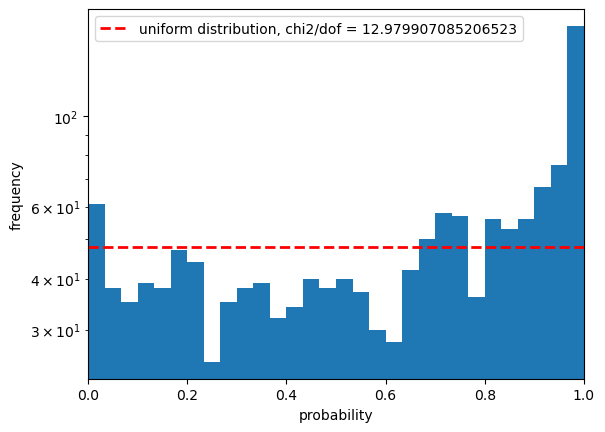

/global/common/software/lsst/gitlab/desc-python-prod/2024-03-04-26-36/py/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


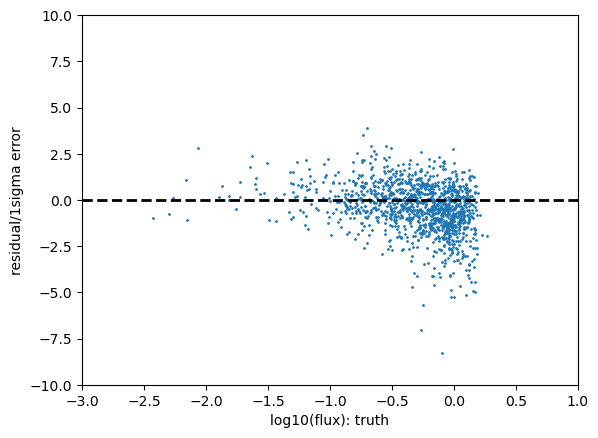

Statistics for  gaap1p0_g
-------------------------
outlier rate:
low outlier fraction:  0.0015 high outlier fraction:  0.0195
Anderson_ksampResult(statistic=60.557822942150295, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
KstestResult(statistic=0.13874755699447527, pvalue=1.4651075091904785e-24, statistic_location=0.6634862329526634, statistic_sign=-1)
CramerVonMisesResult(statistic=11.518623568994787, pvalue=5.302340788659876e-10)


In [149]:
bands=['r','g']
models=['psf','free_psf','cModel']
band = 'r'
flag_list = [ band+'_pixelFlags_bad', band+'_pixelFlags_sensor_edgeCenter', band+'_pixelFlags_offimage', 
             band+'_pixelFlags_clippedCenter',band+'_pixelFlags_crCenter', band+'_pixelFlags_interpolatedCenter',
             band+'_pixelFlags_inexact_psfCenter', band+'_pixelFlags_edge', band+'_pixelFlags_suspectCenter',
             band+'_pixelFlags_saturatedCenter', band+'_pixelFlags_clipped', band+'_pixelFlags_cr',
             band+'_pixelFlags_interpolated', band+'_pixelFlags_saturated', band+'_pixelFlags_sensor_edge',
             band+'_pixelFlags_suspect']


snr_cut = 5.0
mag_cut_i = 25.3
mag_cut_max = 15
model = 'gaap1p0'


mask_flags = (matched_table_galaxies[bands[0]+'_'+model+'Flux']>0)
cut_mag = (matched_table_galaxies[bands[0]+'_'+model+'Flux']>0)

for band in bands:
    # cut on signal to noise of measured values
    mask_flags = mask_flags&((matched_table_galaxies[band+'_'+model+'Flux'])/(matched_table_galaxies[band+'_'+model+'FluxErr'])>snr_cut)    
    mask_flags = mask_flags&(matched_table_galaxies[band+'_extendedness']==1)
    mask_flags = mask_flags&(matched_table_galaxies['detect_isPrimary'])&(matched_table_galaxies['detect_isIsolated'])
    for flag in flag_list:
        mask_flags = mask_flags&(~matched_table_galaxies[flag])
    if model=='cModel':
        # if cModel then the flag is cModel_flag rather than cModelFlux_flag, and we add an apCorr flag
        mask_flags = mask_flags&(~matched_table_galaxies[band+'_'+model+'_flag'])&(~matched_table_galaxies[band+'_'+model+'_flag_apCorr'])
    elif 'gaap' in model:
        mask_flags = mask_flags&(~matched_table_galaxies[band+'_gaapFlux_flag'])
    else:
        mask_flags = mask_flags&(~matched_table_galaxies[band+'_'+model+'Flux_flag'])
    # add a magnitude cut    
    cut_mag = cut_mag&(convert_nanoJansky_to_mag(matched_table_galaxies['flux_i'])<mag_cut_i)
    cut_mag = cut_mag&(convert_nanoJansky_to_mag(matched_table_galaxies['flux_i'])>mag_cut_max)
    
loc = convert_nanoJansky_to_mag(matched_table_galaxies['g_'+model+'Flux'][mask_flags&cut_mag])-convert_nanoJansky_to_mag(matched_table_galaxies['r_'+model+'Flux'][mask_flags&cut_mag])

scale1 = convert_flux_err_to_mag_err(matched_table_galaxies['g_'+model+'Flux'][mask_flags&cut_mag],matched_table_galaxies['g_'+model+'FluxErr'][mask_flags&cut_mag])
scale2 = convert_flux_err_to_mag_err(matched_table_galaxies['r_'+model+'Flux'][mask_flags&cut_mag],matched_table_galaxies['r_'+model+'FluxErr'][mask_flags&cut_mag])
scale = np.sqrt(scale1**2+scale2**2)
sample = convert_nanoJansky_to_mag(matched_table_galaxies['flux_g'][mask_flags&cut_mag])-convert_nanoJansky_to_mag(matched_table_galaxies['flux_r'][mask_flags&cut_mag])

test_result = get_chi2_plots_from_dist(loc,scale,sample,model+'_'+band,0.0001,0.9999,color=True)


## What does this mean?

If you want to see how flags impact the photometry biases and errors you can play around with the set of flags that you might want to use. Take care to look specifically at the fluxes or colors that you want to end up with, and remember to consider flags for deblending and pixel-level failures. 


